# <center> Forecasting COVID-19 cases using SARS-CoV-2 titers in wastewater </center>

### <center> CS109B - Advanced Topics in Data Science (Spring 2021) </center>

#### <u>Project Group #111:</u> <font color='green'><i>Vivek Bhatia, Prakash Bhatt, Lalitanjali Bondili, Raghu Soori</i></font>

<a id="contents"></a>

## Contents

- [**Introduction**](#part1)


- [**Problem Description**](#part2)


- [**Project Question & Proposal**](#part3)


- [**Data Description, Preprocessing & Exploratory Data Analysis**](#part4)

  
- [**Criteria used for Model Selection & Evaluation**](#part5)


- [**Model Building**](#part6)
  - [Baseline Persistence Model](#model1)
  - [Linear & Polynomial Regression Models](#model2)
  - [Generalized Linear Model](#model3)
  - [Generalized Additive Model using PyGAM](#model4)
  - [Deep Neural Network Models](#model5)
  - [XGBoost](#model6)


- [**Model Evaluation & Interpretation**](#part7)


- [**Conclusion & Next Steps**](#part8)


- [**References**](#part9)

<a id="part1"></a>

## INTRODUCTION

[Return to contents](#contents)

Covid-19 is the world's top most priority and is being dealt with in multiple ways. Accurate and timely tracking and forecasting of the COVID-19 cases has helped public health officials make important decisions in policy and response. Since the start of the pandemic, officials have been using symptomatic and clinically reported cases to accurately count the number of cases. This method, however, has inherent drawbacks as many people do not clinically report the cases or are asymptomatic. The recent studies show that presence of viral-RNA in wastewater caused by gastro-intestinal disorder induced by COVID-19 can be used as a critical and reliable indicator to track COVID-19 cases. We are exploring relationship between the viral-RNA content in wastewater and COVID-19 cases and making models to predict the future cases.

<a id="part2"></a>

## PROBLEM DESCRIPTION

Since the start of the SARS-CoV-2 (COVID-19) pandemic, an accurate count of cases in the community is tracked using symptomatically and clinically diagnosed cases. This method has inherent drawbacks as many of the patients do not report the disease and/or maybe asymptomatic [1]. 

Our intention is to prove that titers content in wastewater is more reliable indicator than conventional data collection method to track COVID-19 cases. 

[1] Wu et al. SARS-CoV-2 titers in wastewater foreshadow dynamics and clinical presentation of new COVID-19 cases (202)

[Return to contents](#contents)

<a id="part3"></a>

## PROJECT QUESTION & PROPOSAL

Studies have shown proof of gastro-intestinal disorders triggered by SARS-CoV-2 infections in patients and the occurrence of viral RNA in community wastewater plants [2]. Wastewater-based epidemiological surveillance can be used as an early warning system for disease outbreak and to forecast the rate of transmission in communities.

*We intend to explore the relationship between SARS-CoV-2 titers in urban wastewater and the rate of infections in nearby communities and design models to forecast the rate of infections using titer information as proxy data. We intend to use supervised or self-supervised learning techniques to develop models which can accurately predict the current count of COVID-19 cases in the community using solely the data available from wastewater viral titers*


[2] Xiao et al. Evidence for gastrointestinal infection of SARS-CoV-2 (2020)

[Return to contents](#contents)

#### Run following cells to setup notebook and load required libraries

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [4]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import glob
import seaborn as sns
import matplotlib.dates as mdates
from pygam import LinearGAM, s
from datetime import datetime
import json 

import arviz as az
import pymc3 as pm
import patsy as pt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, matthews_corrcoef
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, MaxPool1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Classifiers
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from math import sqrt

# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
# DO NOT DELETE THIS CELL
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Define Utility Functions for Model evaluation and Plotting

In [6]:
MODELS_DIR = "models"
!mkdir -p $MODELS_DIR
        
def evaluate_model(model_name, y_test, y_predicted, train=False):
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mae = mean_absolute_error(y_test, y_predicted)
    mape = mean_absolute_percentage_error(y_test, y_predicted)
    r_score = r2_score(y_test, y_predicted)
    corr_coeff = pearsonr(y_test, y_predicted)

    # Save model metrics
    metrics = {
        "Time": datetime.utcnow().isoformat(sep=' ', timespec='milliseconds'),
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape, 
        "Correlation Coeff": corr_coeff[0], 
        "R2 Score": r_score,
    }
    suffix = "train" if train else "test"
    # Write to file
    with open(os.path.join(MODELS_DIR, model_name + "_metrics_" + suffix + ".json"), "w") as json_file:
        json_file.write(json.dumps(metrics))

In [7]:
# define function for plotting validation and loss history by epoch

def plot_history(history_dict, title, test_eval=False,
                 loss_only=False, other_metric="accuracy"):
    """Plot training and validation loss and accuracy using keras history object
    """
    x_vals = np.arange(1, len(history_dict["loss"])+1)
    
    fig, ax = plt.subplots(1, 1 if loss_only else 2, figsize=(10, 4))

    plt.suptitle("{}".format(title), fontsize=16, y=1)
        
    if loss_only:
        
            ax.plot(x_vals, history_dict["loss"], "k--", label="train")
            ax.plot(x_vals, history_dict["val_loss"], "k-", label="validation")
            ax.set_xlabel("epoch", fontsize=12)
            ax.set_ylabel("loss", fontsize=12)
            ax.set_xticks(x_vals)
            ax.grid(":", alpha=0.4)
            ax.tick_params(labelsize=10)        
    
    else:
        
        for i, metric in enumerate(["loss", other_metric]):
            ax[i].plot(
                x_vals, history_dict[metric], "k--",
                label="train"
            )
            ax[i].plot(
                x_vals, history_dict["val_{}".format(metric)], "k-",
                label="validation"
            )
            ax[i].set_xlabel("epoch", fontsize=14)
            ax[i].set_ylabel(metric, fontsize=14)
            ax[i].set_xticks(x_vals)
            ax[i].grid(":", alpha=0.4)
            ax[i].tick_params(labelsize=10)

    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

<a id="part4"></a>

## DATA DESCRIPTION, PREPROCESSING & EXPLORATORY DATA ANALYSIS

[Return to contents](#contents)

We have used two data sources which are the MWRA Wastewater COVID-19 Tracking Dataset and the Massachusetts official COVID-19 Case Count Dataset.

1) **The MWRA Wastewater COVID-19 Tracking Data** is collected by the Massachusetts Water Resources Authority. It measures the quantity of SARS-CoV-2 viral RNA samples in sewage wastewater for Boston’s Southern and Northern districts.
 
* The dataset had some missing values that we imputed using ARIMA forecasts.
* Since raw values were noisy, we computed a 7 day rolling average for use as predictor variables

2) **The Massachusetts official COVID-19 Case Count Dataset** is a publicly available dataset provided by the Massachusetts Department of Public Health. This dataset contains the daily case counts per county within the Massachusetts jurisdiction. We primarily use the Norfolk, Suffolk and the Middlesex county data in our analysis.

* Daily case count is available for Massachusetts on a per county level, however, since our waste water RNA signal is combined into Southern and Northern Boston districts, we combined the three counties of Middlesex, Norfolk and Suffolk to get a combined case count for Greater Boston Area.
* Since raw values were noisy, we computed a 7 day rolling average for use as the response variable.
* Missing values in the dataset were imputed using ‘ARIMA’ forecasts.

**Data Alignment:** Time Range for the datasets were aligned to only consider the intersection of dates where both MWRA Signal and Daily Case Counts were available (08/2020 to 05/2021)

**Normalization:** Dataset was normalized to values between [0,1] to allow for standardized comparison scale for neural networks and linear regression models alike.

Finally we split the dataset into **70% and 30% for train and test data** respectively.

All the above mentioned steps are implemented in the following code segments.


In [8]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")

#### Load MWRA Wastewater COVID-19 Tracking Dataset

In [9]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [10]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [11]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship between Southern and Northern Viral Titers Raw Data, $R$:0.78')

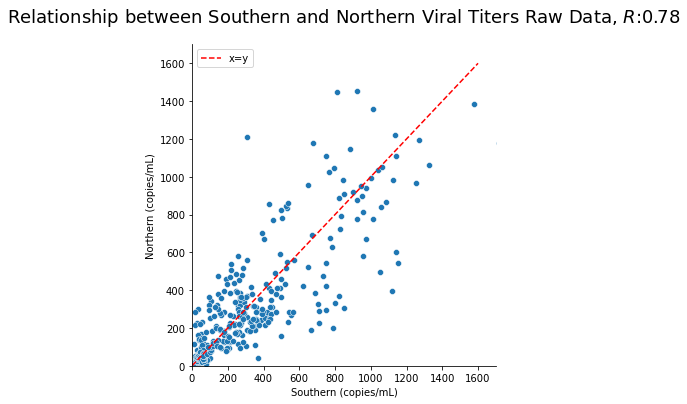

In [12]:
# Show the relation between northern and southern samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
r_value = pearsonr(df_mwra["Southern (copies/mL)"],df_mwra["Northern (copies/mL)"])
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title(f'Relationship between Southern and Northern Viral Titers Raw Data, $R$:{r_value[0]:.2f}', fontsize=18, y=1.05)

Text(0.5, 1.05, 'Relationship between Southern and Northern Viral Titers Average Data, $R$:0.92')

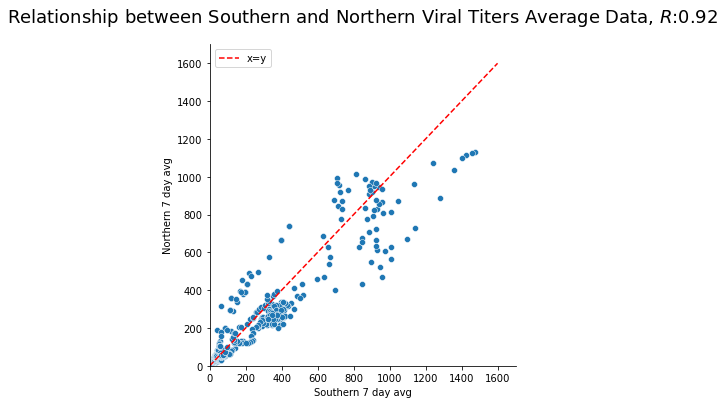

In [13]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern 7 day avg", y="Northern 7 day avg")
r_value = pearsonr(df_mwra["Southern 7 day avg"],df_mwra["Northern 7 day avg"])
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title(f'Relationship between Southern and Northern Viral Titers Average Data, $R$:{r_value[0]:.2f}', fontsize=18, y=1.05)

#### Plot time series data for Southern and Northern values and their 7-day averages

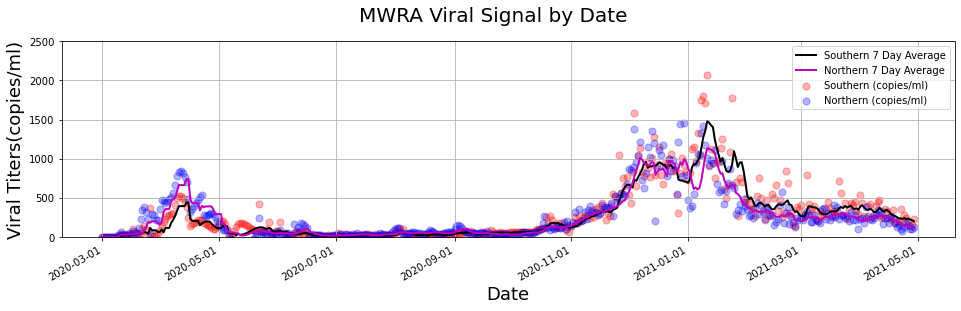

In [14]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

#### Load dataset showing Massachusetts official COVID-19 Case Count

In [15]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [16]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

#### Handle missing values and NaNs

In [17]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [18]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


#### Plotting case counts by counties Middlesex, Norfolk and Suffolk

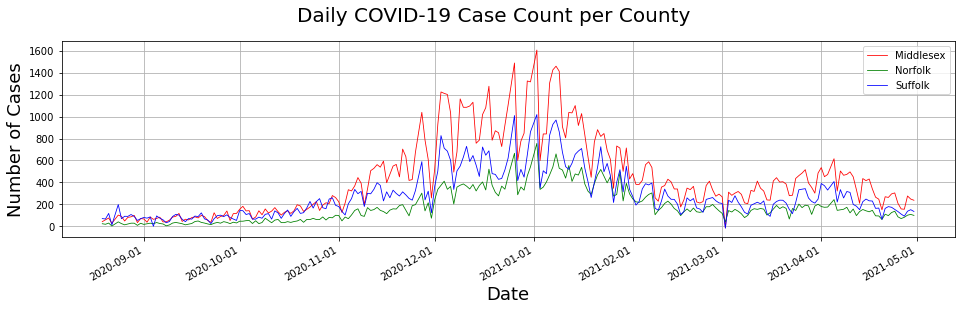

In [19]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [20]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135.0,16.0
1,2020-08-20,142.0,3.0
2,2020-08-21,221.0,3.0
3,2020-08-22,41.0,6.0
4,2020-08-24,340.0,13.0
...,...,...,...
245,2021-04-26,339.0,5.0
246,2021-04-27,329.0,1.0
247,2021-04-28,514.0,4.0
248,2021-04-29,507.0,5.0


#### Plot Covid cases and Titer data as time series to view their relationship 

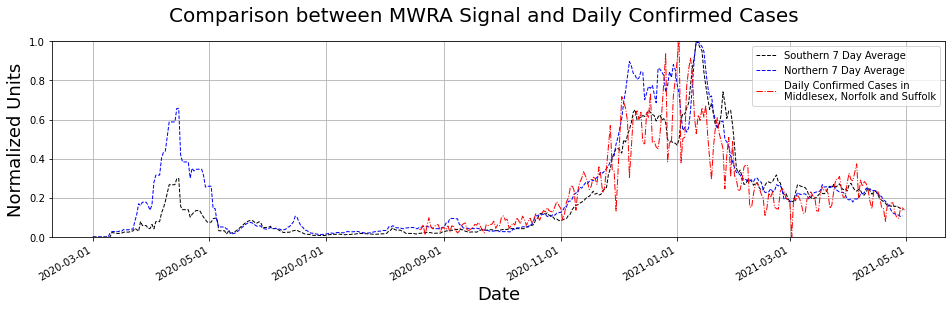

In [21]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [22]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern_Raw', 'Northern_Raw', 'Combined_Raw', 
                                              'Southern_Avg', 'Northern_Avg', 'Combined_Avg', 
                                                'Southern_Variant', 'Northern_Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern_Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern_Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Combined_Raw'] = (row['Southern (copies/mL)'].to_list()[0] + row['Northern (copies/mL)'].to_list()[0]) / 2
        df_aligned.at[i, 'Southern_Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern_Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern_Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern_Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

In [23]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [24]:
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50.0,87.0,68.5,28.0,56.0,NaN,0,0,135.0,16.0,5.561524,0.659144
1,2020-08-20,43.068345,74.287119,58.677732,28.0,56.0,NaN,0,0,142.0,3.0,5.8499,0.123589
2,2020-08-21,35.0,60.0,47.5,35.0,61.0,NaN,0,0,221.0,3.0,9.104422,0.123589
3,2020-08-22,28.525255,49.594218,39.059737,35.0,61.0,NaN,0,0,41.0,6.0,1.689056,0.247179
4,2020-08-24,21.0,38.0,29.5,33.0,58.0,NaN,0,0,340.0,13.0,14.006802,0.535554


In [25]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases_Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths_Avg'] = df_aligned['Deaths'].rolling(window=7).mean()
# Also add average for southern and northern combined titers
df_aligned['Combined_Avg'] = df_aligned['Combined_Raw'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

In [26]:
# Finally normalize all values using MinMaxScaler
to_transform = ['Southern_Raw', 'Northern_Raw', 'Combined_Raw', 'Southern_Avg', 'Northern_Avg', 'Combined_Avg', 'Cases', 'Deaths', 'Cases_Avg', 'Deaths_Avg', 'Cases_per_100K', 'Deaths_per_100K'] 
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[to_transform] = scaler.fit_transform(df_aligned[to_transform])
df_aligned = df_scaled
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K,Cases_Avg,Deaths_Avg
0,2020-08-19,0.008260,0.046154,0.017956,0.000000,0.023636,0.003742,0,0,0.038211,0.400,0.038211,0.400,0.014857,0.204301
1,2020-08-20,0.006413,0.037264,0.013434,0.000000,0.023636,0.003742,0,0,0.040284,0.075,0.040284,0.075,0.014857,0.204301
2,2020-08-21,0.004263,0.027273,0.008287,0.004834,0.028182,0.003742,0,0,0.063685,0.075,0.063685,0.075,0.014857,0.204301
3,2020-08-22,0.002538,0.019996,0.004401,0.004834,0.028182,0.003742,0,0,0.010367,0.150,0.010367,0.150,0.014857,0.204301
4,2020-08-24,0.000533,0.011888,0.000000,0.003453,0.025455,0.003742,0,0,0.098934,0.325,0.098934,0.325,0.014857,0.204301


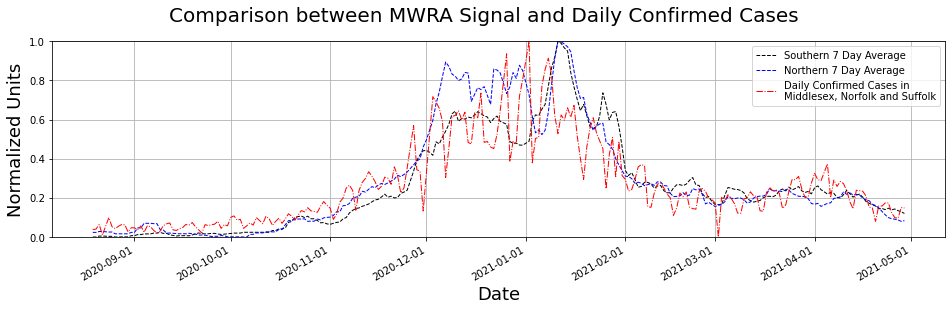

In [27]:
# Plot the timeseries data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Southern_Avg'].to_numpy(), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Northern_Avg'].to_numpy(), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases'].to_numpy(), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

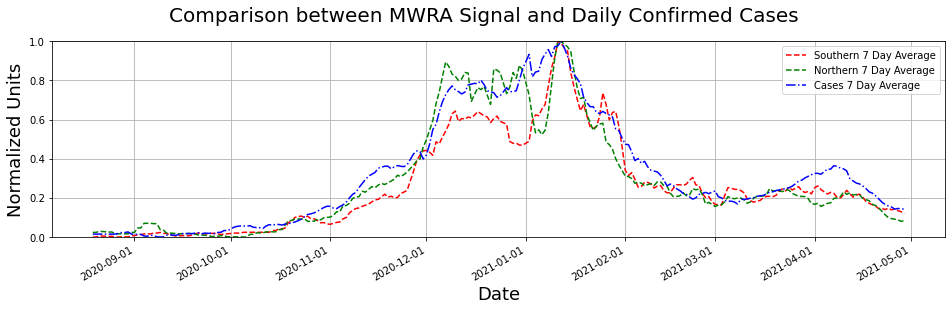

In [28]:
# Plot the timeseries data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Southern_Avg'].to_numpy(), '--r', linewidth = 1.5,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Northern_Avg'].to_numpy(), '--g', linewidth = 1.5, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases_Avg'].to_numpy(), '-.b', linewidth = 1.5, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], df_aligned['Deaths_Avg'].to_numpy(), '-.m', linewidth = 1.5, label="Death 7 Day Average")

#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

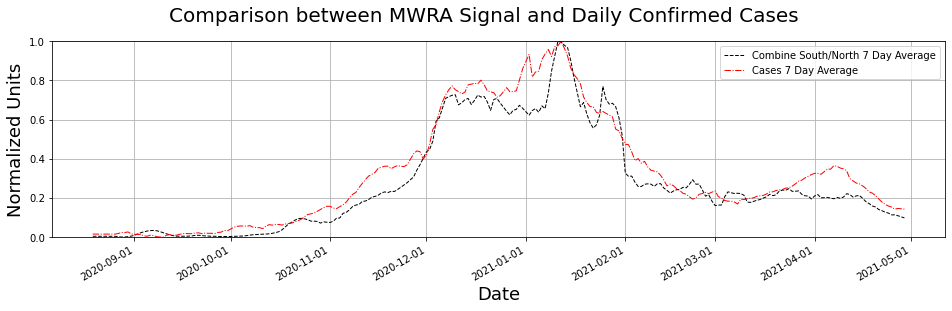

In [29]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Combined_Avg'].to_numpy(), '--k', linewidth = 1,  label="Combine South/North 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases_Avg'].to_numpy(), '-.r', linewidth = 1, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

Text(0.5, 1.05, 'Relationship between Combined Titers and New Confirmed Cases , $R$:0.97')

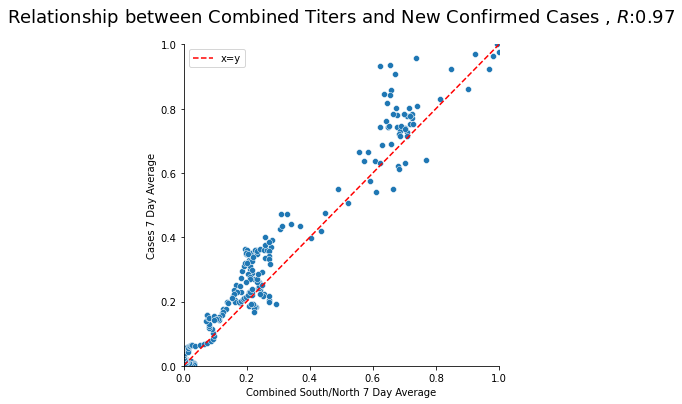

In [30]:
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Combined_Avg", y="Cases_Avg")
r_value = pearsonr(df_scaled["Combined_Avg"],df_scaled["Cases_Avg"])
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Combined South/North 7 Day Average")
plt.ylabel("Cases 7 Day Average")
plt.legend()
plt.title(f'Relationship between Combined Titers and New Confirmed Cases , $R$:{r_value[0]:.2f}', fontsize=18, y=1.05)

In [31]:
# Create Lagged Dataset for Persistence Model
n_lags = 7
for i in range(1,n_lags+1):
    label = f'Cases_Avg(t-{i})'
    df_aligned[label] = df_aligned['Cases_Avg'].shift(i)

# fill nan to avoid problems in modeling
df_aligned.interpolate(limit_direction="both", inplace=True)
display(df_aligned.head(5))

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,...,Deaths_per_100K,Cases_Avg,Deaths_Avg,Cases_Avg(t-1),Cases_Avg(t-2),Cases_Avg(t-3),Cases_Avg(t-4),Cases_Avg(t-5),Cases_Avg(t-6),Cases_Avg(t-7)
0,2020-08-19,0.008260,0.046154,0.017956,0.000000,0.023636,0.003742,0,0,0.038211,...,0.400,0.014857,0.204301,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857
1,2020-08-20,0.006413,0.037264,0.013434,0.000000,0.023636,0.003742,0,0,0.040284,...,0.075,0.014857,0.204301,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857
2,2020-08-21,0.004263,0.027273,0.008287,0.004834,0.028182,0.003742,0,0,0.063685,...,0.075,0.014857,0.204301,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857
3,2020-08-22,0.002538,0.019996,0.004401,0.004834,0.028182,0.003742,0,0,0.010367,...,0.150,0.014857,0.204301,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857
4,2020-08-24,0.000533,0.011888,0.000000,0.003453,0.025455,0.003742,0,0,0.098934,...,0.325,0.014857,0.204301,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857,0.014857


<a id="part5"></a>

## CRITERIA USED FOR MODEL SELECTION & EVALUATION

Given the strong linear relationship between the titer average values and the confirmed daily case count average values, we suspect linear regression models might work best for this problem. We explored the use of the following models for forecasting daily case count:

#### Models Explored
* **Naive Model** - We developed a baseline persistence model for evaluating performance of other models. This model uses the case count values from previous day (t-1) to predict the values for the current day (t).

* **Linear and Polynomial Regression** - We evaluated the use of simple linear and regression models solved using Ordinary Least-Squares.

* **Generalized Linear Models** - We suspect piece-wise linear models like GAMs might tend to work better than simple linear models, we develop such a model using Penalized B-Splines.

* **Recurrent Neural Networks** - Since our time series data is sequential, we explored the use of recurrent neural networks such as Gated Recurrent Units, Long Short Term Memory (LSTM) models with and without Bidirectional Layers to create deep neural networks.

* **Gradient Boosting Regression** - We also built XGBoost models which are heavily used at an industry-level for time series problems like these where the dataset size is small. We also wanted to generate feature importance plots to learn about the important features.


#### Metrics considered
For model evaluation, we use common metrics for time series comparison in similar forecasting problems for evaluating the performance of our models relative to the naive model. We wanted to compare the models using the following metrics:
* Root Mean Squared Error (RMSE)
* Mean Absolute Error(MAE)
* Mean Absolute Percentage Error (MAPE)
* R-Squared Score
* Pearson's Correlation Coefficient (R-Value)

[Return to contents](#contents)

<a id="part6"></a>

## MODEL BUILDING

[Return to contents](#contents)

In [32]:
# Add additional features related to date to model
df_aligned['dayofweek'] = df_aligned['Date'].dt.dayofweek
df_aligned['dayofmonth'] = df_aligned['Date'].dt.day

In [33]:
# Scale the new features as well
to_transform = ['dayofweek', 'dayofmonth'] 
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[to_transform] = scaler.fit_transform(df_aligned[to_transform])
df_aligned = df_scaled

In [34]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


<a id="model1"></a>

## Persistence Model

[Return to contents](#contents)

In [35]:
# Create training and test labels for persistence model
X_train, y_train = df_train['Cases_Avg(t-1)'], df_train['Cases_Avg'],
X_test, y_test = df_test['Cases_Avg(t-1)'], df_test['Cases_Avg']

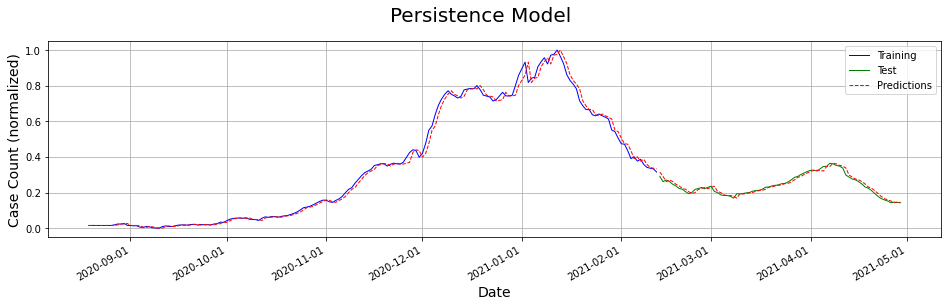

In [36]:
# plot persistence predictions and expected results
# The train_X and test_X are the predictions for the persistence model
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_train['Date'], X_train, '--r', linewidth = 1)
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_test['Date'], X_test, '--r', linewidth = 1,  label="Predictions")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)


fig.autofmt_xdate()
fig.suptitle('Persistence Model', fontsize=20, y=1.00)
fig.show()

In [37]:
# Evaluated Model
# For persistence X_test values are the predictions
evaluate_model("Persistence", y_train, X_train, train = True)
evaluate_model("Persistence", y_test, X_test)

<FONT color='red'> INTERPRETATION:
</FONT>

We use the persistence model as a baseline to compare the performance of other models in thier prediction capabilities. The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1). In the preprocessing stage of this project, we calculated a variable called Case_Avg which is the 7 day rolling average of the original case counts. In the persistence mode, we use Cases_Avg(t-1) to predict Cases_Avg(t).

The persistence plot above shows that the model's predictive capacity is good as it is able to following the trend in both the train and test set. There is a lag of 1 day in the training predictions which is expected and the test predictions closely correspond to the reality.









<a id="model2"></a>

## Multiple Linear Regression Model

[Return to contents](#contents)

In the exploratory data analysis process, we noticed a strong correlation between the 7-day average case counts and the southern/northern 7 day average titer values. In the initial models, we have implemented linear regression, polynomial regression with degrees 2,3,5 and 8.

In [38]:
labels = []
use_n_lags = 1
for i in range(1,use_n_lags+1):
    labels.append(f'Cases_Avg(t-{i})')

#predictor_variables = ['Southern_Avg', 'Northern_Avg']
predictor_variables = labels + ['Southern_Avg', 'Northern_Avg', 'dayofweek', 'dayofmonth']
response_variable = 'Cases_Avg'

In [39]:
# Linear Regression Model
# Create training and test features with intercepts
X_train = df_train[predictor_variables].astype('float')
X_train = sm.add_constant(X_train) # adding a constant
y_train = df_train[response_variable].astype('float')

X_test = df_test[predictor_variables].astype('float')
X_test = sm.add_constant(X_test) # adding a constant
y_test = df_test[response_variable].astype('float')

# Fit the model
model_lm1 = sm.OLS(y_train, X_train).fit()

# Print summary
model_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Cases_Avg   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     7152.
Date:                Mon, 10 May 2021   Prob (F-statistic):          1.09e-193
Time:                        20:49:42   Log-Likelihood:                 417.44
No. Observations:                 174   AIC:                            -822.9
Df Residuals:                     168   BIC:                            -803.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0076      0.005      1.667      0.097      -0.001       0.017
Cases_Avg(t-1)     0.9559      0.028     34.466      0.000       0.901       1.011
Southern_Avg      -0.0602      0.028     -2.186      0.030      -0.115      -0.006
Northern_Avg       0.0945      0.020      4.829      0.000       0.056       0.133
dayofweek         -0.0003      0.005     -0.062      0.951      -0.010       0.010
dayofmonth        -0.0079      0.006     -1.374      0.171      -0.019       0.003
==============================================================================
Omnibus:                       22.218   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.461
Skew:                          -0.064   Prob(JB):                     6.26e-25
Kurtosis:                       6.919   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

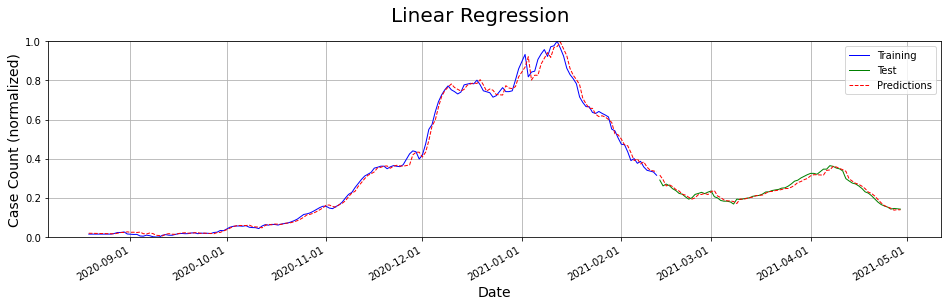

In [40]:
# Get predictions
train_preds = model_lm1.get_prediction(X_train).summary_frame()
test_preds = model_lm1.get_prediction(X_test).summary_frame()

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
#ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
#                train_preds['mean_ci_upper'], color='b', alpha=.2)

#ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
#                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Linear Regression', fontsize=20, y=1.00)
fig.show()

In [41]:
# Evaluate Model
evaluate_model("Linear", y_train, train_preds['mean'], train=True)
evaluate_model("Linear", y_test, test_preds['mean'])

## Polynomial Regression

In [42]:
def generate_poly_features(x, degree):
    poly = PolynomialFeatures(degree=degree)
    xp = poly.fit_transform(x)
    return xp

def generate_polynomial_model(x, y, degree):
    xp = generate_poly_features(x, degree)
    return xp, sm.OLS(y, xp).fit()

/usr/share/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


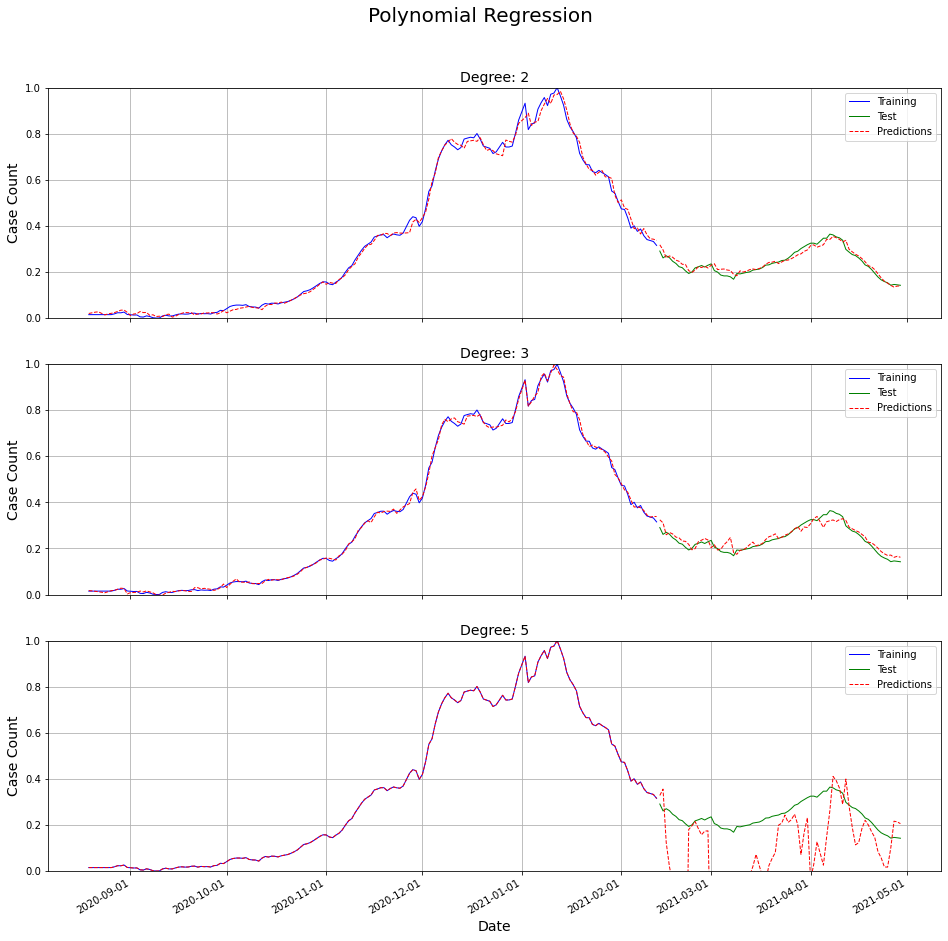

In [43]:
#your code here
poly_models = list()
degrees = [2,3,5]

# plot predictions and expected results
fig, ax = plt.subplots(nrows = len(degrees), ncols = 1, sharey=True, figsize=(16,16))
ax = ax.flatten()

for i, degree in enumerate(degrees):

    # Generate model
    y_train = df_train[response_variable].astype('float')
    X_train , model = generate_polynomial_model(df_train[predictor_variables].astype('float'), 
                                                y_train, 
                                                degree)
    
    # Add model to list
    poly_models.append(model)
    
    # Generate x_test
    y_test = df_test[response_variable].astype('float')
    X_test = generate_poly_features(df_test[predictor_variables].astype('float'), degree)

    # Generate predictions
    train_preds = model.get_prediction(X_train).summary_frame()
    test_preds = model.get_prediction(X_test).summary_frame()
    
    ax[i].plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
    ax[i].plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
    ax[i].plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
    ax[i].plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

    # CI for the predection at each x value, i.e. the line itself
    #ax[i].fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
    #                train_preds['mean_ci_upper'], color='b', alpha=.2)

    #ax[i].fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
    #                test_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].grid(True)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_title(f'Degree: {degree}', fontsize=14)
    ax[i].set_ylabel(f'Case Count', fontsize = 14)
    ax[i].set_xlabel('Date', fontsize = 14)
    ax[i].set_ylim([0,1])
    
    # Evaluate Model
    evaluate_model(f"Polynomial Order: {degree}", y_train, train_preds['mean'], train=True)
    evaluate_model(f"Polynomial Order: {degree}", y_test, test_preds['mean'])
    
fig.autofmt_xdate()
fig.suptitle('Polynomial Regression', fontsize=20, y=0.95)
fig.show()

INTERPRETATION:

We see that increasing the degree for the polynomial models results in an ill fitting predicted outcome. The increase in the polynomial order generally fits the curve close to the original data but increasing the order too much results in higher variance due to overfitting. From the plots, we notice that polynomial orders of 2 and 3 perform reasonably well whereas order of 5 severely overfits to the training data and results in bad predictions.


<a id="model3"></a>

## Generalized Linear Model with Poisson Regression

$\theta = exp(\beta_0 + \beta_1 X_1 + \beta_2 X_2)$


$Y_{count} \sim Poisson(\theta)$

[Return to contents](#contents)

In [44]:
x1 = df_aligned['Southern_Avg']
x2 = df_aligned['Northern_Avg']
x3 = df_aligned['Cases_Avg(t-1)']
y_obs = df_aligned['Cases_Avg']

In [45]:
with pm.Model() as model_glm_poisson:

    # Define Prior Distributions (Betas)
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_Southern", mu=0, sigma=10)
    b2 = pm.Normal("b2_Northern", mu=0, sigma=10)
    b3 = pm.Normal("b3_Persistence", mu=0, sigma=10)
    
    # Deterministic variable
    # define linear model and exp link function
    #theta = (b0 + b1*x1 + b2*x2)
    theta = pm.Deterministic('theta',pm.math.exp(b0 + b1*x1 + b2*x2 + b3*x3))

    # Likelihood function Y ~ Poisson(theta)
    ## Define Poisson likelihood
    Y_obs = pm.Poisson("Y_obs", mu=theta, observed=y_obs)

In [46]:
#pm.model_to_graphviz(model_glm_poisson)

In [47]:
np.seterr(divide='ignore') # Suppress divide by zero warning
with model_glm_poisson:
    print(f'Starting MCMC process')
    nsamples = 20000 # number of samples to keep
    burnin = 4000 # burnin period
    trace = pm.sample(nsamples, tune=burnin, target_accept=0.9, cores=4, random_seed = 109, return_inferencedata=False) # return_inferencedata = False to suppress warning 
    print(f'DONE')

Starting MCMC process


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b3_Persistence, b2_Northern, b1_Southern, b0_intercept]


Sampling 4 chains for 4_000 tune and 20_000 draw iterations (16_000 + 80_000 draws total) took 65 seconds.
There were 1972 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2425 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1771 divergences after tuning. Increase `target_accept` or reparameterize.


DONE


/usr/share/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


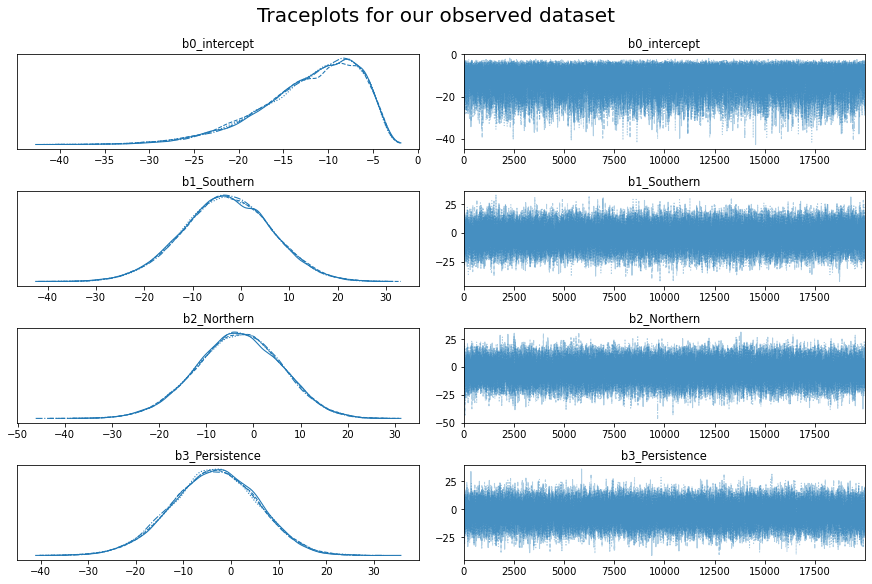

In [48]:
# Plot only mu0, tau0 and beta1,2,3
varnames = ['b0_intercept', 'b1_Southern', 'b2_Northern', 'b3_Persistence']
title = f'Traceplots for our observed dataset'
az.plot_trace(trace, var_names = varnames, compact=True, divergences = None);
plt.suptitle( title, fontsize=20 )
plt.show()

In [49]:
print(f'R-hat values for hidden parameters')
results = az.summary(
    trace, 
    var_names = varnames
)
display(results)

R-hat values for hidden parameters


/usr/share/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_intercept,-12.103,5.661,-22.492,-3.362,0.043,0.031,20597.0,23347.0,1.0
b1_Southern,-2.979,9.237,-20.416,14.339,0.050,0.038,33861.0,37569.0,1.0
b2_Northern,-3.241,9.127,-20.437,13.752,0.055,0.039,27787.0,35676.0,1.0
b3_Persistence,-3.482,9.073,-20.852,13.185,0.052,0.038,30692.0,35908.0,1.0


/usr/share/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

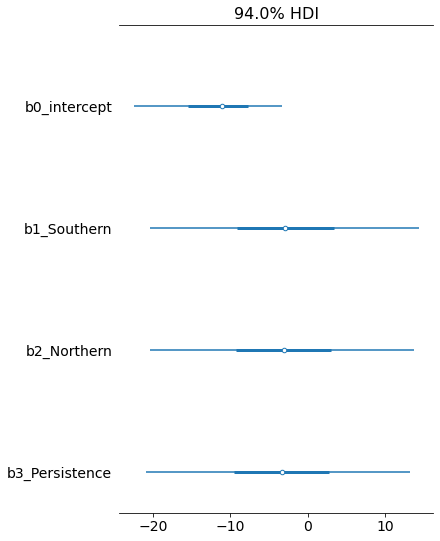

In [50]:
az.plot_forest(trace, var_names = varnames, combined=True)

In [51]:
def model_glm_predict(trace, x):
    beta0 = trace['b0_intercept']
    beta1 = trace['b1_Southern']
    beta2 = trace['b2_Northern']
    
    # Create the prediction model
    x1 = x[0]
    x2 = x[1]
    
    # Theta
    m_theta = np.outer(beta0, np.ones(shape=(len(x1),))) +\
                np.outer(beta1, x1) +\
                np.outer(beta2, x2)
    
    m_mus = np.exp(m_theta)
    m_y = np.mean(m_mus, axis=0)
    
    # Pick most frequent value
    return m_y

mus = model_glm_predict(trace, [x1,x2])

<FONT color='red'> INTERPRETATION:
</FONT>

<a id="model4"></a>

## Generalized Additive Model using PyGAM

[Return to contents](#contents)

In [52]:
X_train, y_train = df_train[predictor_variables].astype('float'), df_train[response_variable].astype('float')
X_test, y_test = df_test[predictor_variables].astype('float'), df_test[response_variable].astype('float')

#formula = s(0) + s(1)
#model_gam = LinearGAM(formula).fit(X_train, y_train)

In [53]:

# Create our model, we'll use grid search to find best smoothing parameter for each feature using a randomized 
# search grid as suggested by pyGAM docs
# https://readthedocs.org/projects/pygam/downloads/pdf/latest/
n_features = len(predictor_variables) # Southern_Avg and Northern_Avg
lams = 10 ** (np.random.rand(100, n_features) * 6 - 3)

formula = s(0)
for i in range(1,n_features):
    formula += s(i)
    
gam = LinearGAM(formula)
gam.gridsearch(X_train.to_numpy(), y_train.to_numpy(), lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

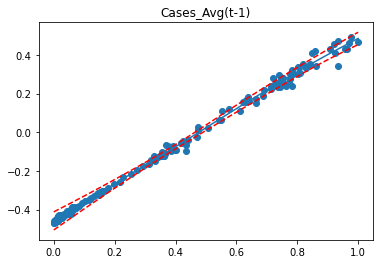

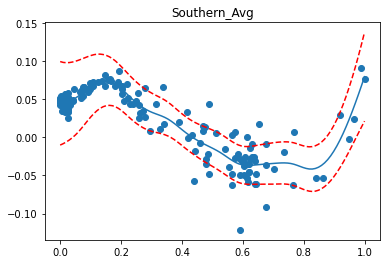

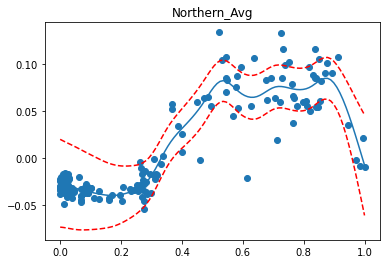

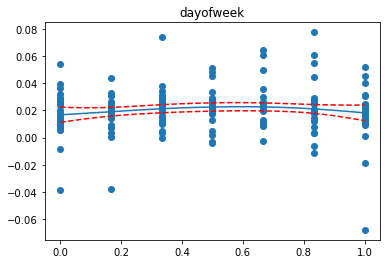

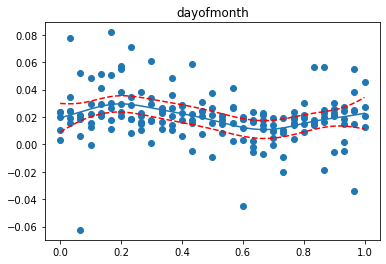

In [54]:
#your code here
res = gam.deviance_residuals(X_train,y_train)
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = gam.partial_dependence(term=i, X=X_train, width=0.95)
    plt.figure()
    plt.scatter(X_train.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X_train.columns.values[term.feature])
    plt.show()

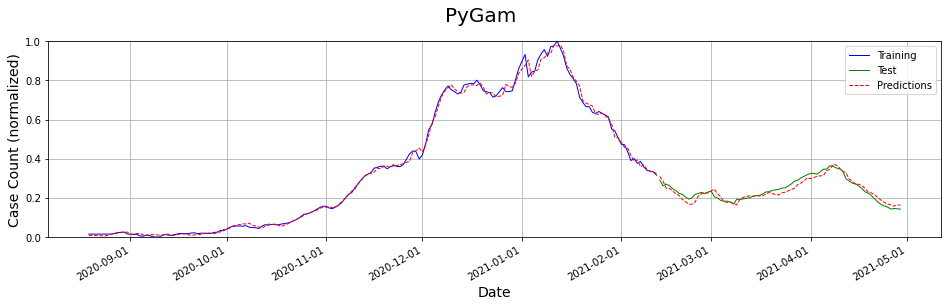

In [55]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], gam.predict(X_train), '--r', linewidth = 1)
ax.plot(df_test['Date'], gam.predict(X_test), '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
#ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
#                train_preds['mean_ci_upper'], color='b', alpha=.2)

#ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
#                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('PyGam', fontsize=20, y=1.00)
fig.show()

In [56]:
# Evaluate Model
evaluate_model("GAM", y_train, gam.predict(X_train), train=True)
evaluate_model("GAM", y_test, gam.predict(X_test))

<FONT color='red'> INTERPRETATION:
</FONT>

<a id="model5"></a>

## Deep Neural Network Models

[Return to contents](#contents)

We use deep learning models such as CNN, GRU, LSTMs and bi-directional models as they offer a lot of promise in time series forecasting type of problems. They have the capacity to automatically learn temporal dependence and automatically handle temporal structures like trends and seasonality within the training data. 


In [57]:
X_train = df_train[predictor_variables].astype('float').to_numpy()
y_train = df_train[response_variable].astype('float').to_numpy()

X_test = df_test[predictor_variables].astype('float').to_numpy()
y_test = df_test[response_variable].astype('float').to_numpy()

In [58]:
# GRUs and LSTMs expect a 3D input, so converting the train and test data

def convert_dataset_3d (X, y, time_steps=1):
    X_values, y_values = [], []
    for i in range(len(X) - time_steps):
        X_values.append(X[i: i+time_steps, :])
        y_values.append(y[i+time_steps])
    return np.array(X_values), np.array(y_values)

TIME_STEPS = 7

X_train, y_train = convert_dataset_3d(X_train, y_train.reshape(-1,1), TIME_STEPS)
X_test, y_test = convert_dataset_3d(X_test, y_test.reshape(-1,1), TIME_STEPS)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (167, 7, 5)
y_train.shape:  (167, 1)
X_test.shape:  (68, 7, 5)
y_test.shape:  (68, 1)


In [59]:
# Hyperparameters
n_units_1 = 64
n_units_2 = 32

drop_rate = 0.1
batch_size = 8
epochs = 50
validation_split = 0.2
verbose = 1
optimizer = Adam(learning_rate = 0.0006)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

## Convolutional Neural Network (Conv-1D) Model

In [60]:
tf.keras.backend.clear_session()

# Define simple 1D CNN model
model_cnn = Sequential()

model_cnn.add(Conv1D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu', 
               input_shape=([X_train.shape[1], X_train.shape[2]])))
#model_cnn.add(MaxPool1D(pool_size = 2))
model_cnn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu'))

model_cnn.add(GRU(128, return_sequences = True, recurrent_dropout = 0.3))
model_cnn.add(GRU(64, recurrent_dropout = 0.3))

#model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation = 'relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(32, activation = 'relu'))
#model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 128)            24704     
_________________________________________________________________
gru (GRU)                    (None, 3, 128)            99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [61]:
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_cnn.load_weights(os.path.join(MODELS_DIR,'model_cnn.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_cnn.pkl'), "rb") as filehandler:
        history_cnn = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_cnn = history_cnn.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_cnn.pkl'), "wb") as filehandler:
        pickle.dump(history_cnn, filehandler)
    # save model weights for future use
    model_cnn.save_weights(os.path.join(MODELS_DIR,'model_cnn.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 14s 52ms/step - loss: 0.1949 - val_loss: 0.2591
Epoch 2/50
17/17 [==============================] - 0s 20ms/step - loss: 0.1203 - val_loss: 0.1398
Epoch 3/50
17/17 [==============================] - 0s 19ms/step - loss: 0.1053 - val_loss: 0.0501
Epoch 4/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0532 - val_loss: 0.0188
Epoch 5/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0410 - val_loss: 0.0132
Epoch 6/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0311 - val_loss: 0.0151
Epoch 7/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0148 - val_loss: 0.0329
Epoch 8/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0110 - val_loss: 0.0366
Epoch 9/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0096 - val_loss: 0.0344
Epoch 10/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0117 - val_loss: 0.0361

...mode

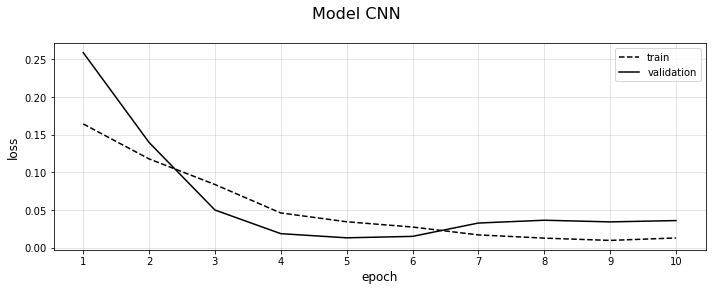

In [62]:
plot_history(history_cnn, "Model CNN", loss_only=True)

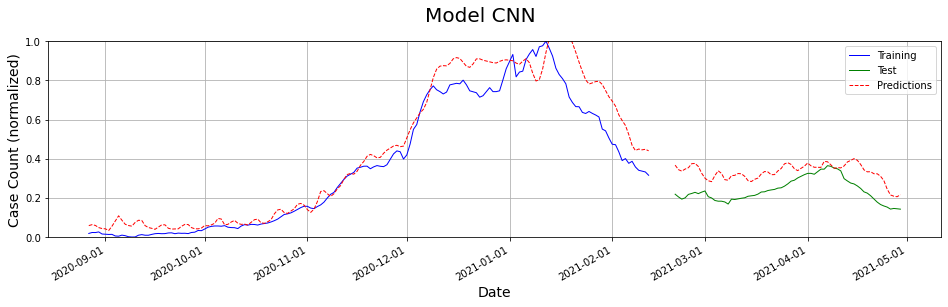

In [63]:
train_predictions = model_cnn.predict(X_train)
test_preds = model_cnn.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model CNN', fontsize=20, y=1.00)
fig.show()

In [64]:
# Evalute Model
evaluate_model("CNN", y_train.flatten(), train_predictions.flatten(), train=True)
evaluate_model("CNN", y_test.flatten(), test_preds.flatten())

## GRU Model

GRU's are similar to RNN architecture, but with the addition of two new gates:
- Reset Gate
- Update Gate

RESET gate is similar to skip connection which allows us to "forget" hidden weights, UPDATE gate allows to update weights in our model. 

GRU helps reduce the vanishing gradient problem prevalent in RNN

In [65]:
# Define GRU Model
model_gru = Sequential()
model_gru.add(tf.keras.layers.GRU(n_units_1, 
                                  return_sequences = True, 
                                  input_shape = [X_train.shape[1], X_train.shape[2]], 
                                  dropout = 0.0, recurrent_dropout = 0.3))
model_gru.add(tf.keras.layers.GRU(n_units_2, dropout = 0.0, recurrent_dropout = 0.3))
model_gru.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile model
model_gru.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7, 64)             13632     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________


In [66]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_gru.load_weights(os.path.join(MODELS_DIR,'model_gru.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_gru.pkl'), "rb") as filehandler:
        history_gru = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_gru = model_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_gru = history_gru.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_gru.pkl'), "wb") as filehandler:
        pickle.dump(history_gru, filehandler)
    # save model weights for future use
    model_gru.save_weights(os.path.join(MODELS_DIR,'model_gru.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 3s 58ms/step - loss: 0.1784 - val_loss: 0.2443
Epoch 2/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1125 - val_loss: 0.1231
Epoch 3/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0562 - val_loss: 0.0566
Epoch 4/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0408 - val_loss: 0.0254
Epoch 5/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0275 - val_loss: 0.0148
Epoch 6/50
17/17 [==============================] - 1s 34ms/step - loss: 0.0210 - val_loss: 0.0105
Epoch 7/50
17/17 [==============================] - 1s 34ms/step - loss: 0.0145 - val_loss: 0.0084
Epoch 8/50
17/17 [==============================] - 1s 35ms/step - loss: 0.0122 - val_loss: 0.0077
Epoch 9/50
17/17 [==============================] - 1s 35ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 10/50
17/17 [==============================] - 1s 34ms/step - loss: 0.0056 - val_loss: 0.0103
Epoch 11/

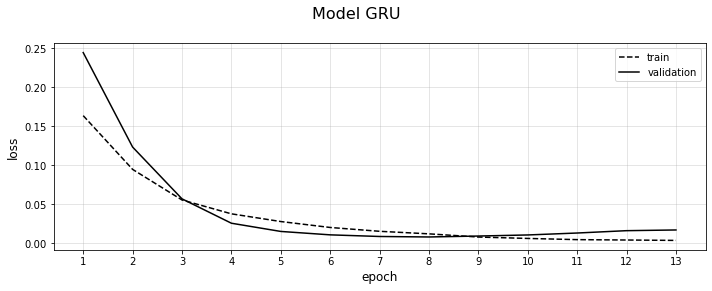

In [67]:
plot_history(history_gru, "Model GRU", loss_only=True)

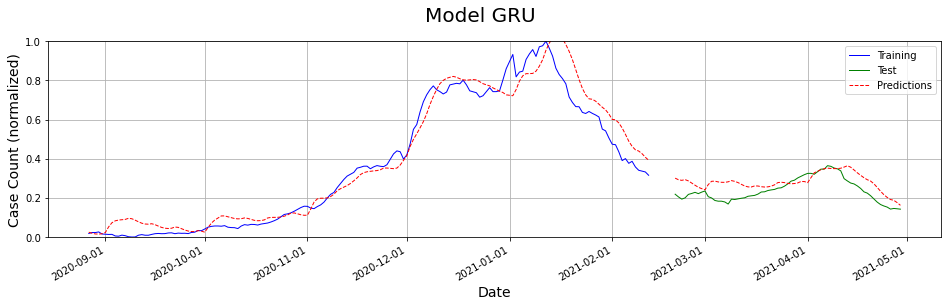

In [68]:
train_predictions = model_gru.predict(X_train)
test_preds = model_gru.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model GRU', fontsize=20, y=1.00)
fig.show()

In [69]:
# Evalute Model
evaluate_model("GRU", y_train.flatten(), train_predictions.flatten(), train=True)
evaluate_model("GRU", y_test.flatten(), test_preds.flatten())

## LSTM 

LSTM has three gates
* Input gate
* Output gate
* Forget gate

LSTM is more accurate on dataset using longer sequences.

In [70]:
# Define LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(n_units_1, return_sequences = True, 
                    input_shape = [X_train.shape[1], X_train.shape[2]], 
                    dropout = 0.0, recurrent_dropout = 0.3))
#model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(LSTM(n_units_2, dropout = 0.0, recurrent_dropout = 0.3))
model_lstm.add(Dense(1, activation='linear'))

# Compile model
model_lstm.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [71]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_lstm.load_weights(os.path.join(MODELS_DIR,'model_lstm.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_lstm.pkl'), "rb") as filehandler:
        history_lstm = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_lstm = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_lstm = history_lstm.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_lstm.pkl'), "wb") as filehandler:
        pickle.dump(history_lstm, filehandler)
    # save model weights for future use
    model_lstm.save_weights(os.path.join(MODELS_DIR,'model_lstm.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 4s 58ms/step - loss: 0.1571 - val_loss: 0.2432
Epoch 2/50
17/17 [==============================] - 1s 37ms/step - loss: 0.1206 - val_loss: 0.1496
Epoch 3/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0754 - val_loss: 0.0872
Epoch 4/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0522 - val_loss: 0.0444
Epoch 5/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0267 - val_loss: 0.0250
Epoch 6/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0212 - val_loss: 0.0178
Epoch 7/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0152 - val_loss: 0.0174
Epoch 8/50
17/17 [==============================] - 1s 43ms/step - loss: 0.0099 - val_loss: 0.0179
Epoch 9/50
17/17 [==============================] - 1s 43ms/step - loss: 0.0075 - val_loss: 0.0210
Epoch 10/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0044 - val_loss: 0.0218
Epoch 11/

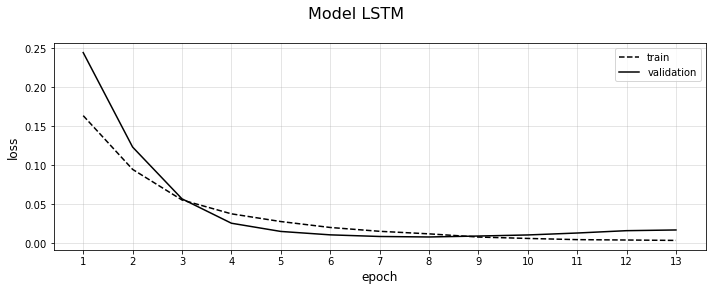

In [72]:
plot_history(history_gru, "Model LSTM", loss_only=True)

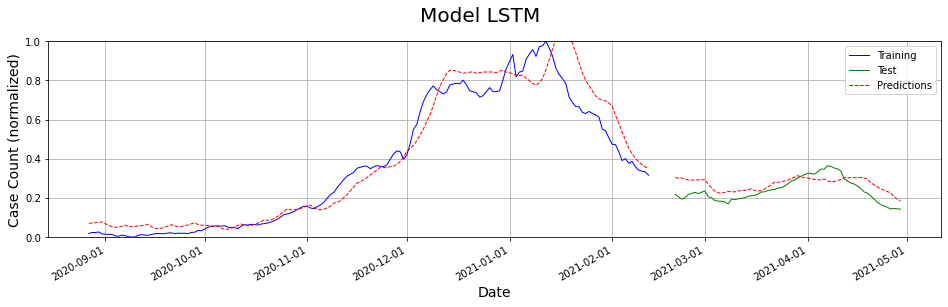

In [73]:
train_predictions = model_lstm.predict(X_train)
test_preds = model_lstm.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model LSTM', fontsize=20, y=1.00)
fig.show()

In [74]:
# Evalute Model
evaluate_model("LSTM", y_train.flatten(), train_predictions.flatten(), train=True)
evaluate_model("LSTM", y_test.flatten(), test_preds.flatten())

## Bidirectional GRU

**BiDirectional GRU** consists of two separate gated recurrent units. One processing the sequence from left to right, the other processes that same sequence but in reverse, from right to left. The output of the two units are then concatenated together and fed to the next layer of the network. 

This allows the network to learn from forward sequences and by reversing the sequence and learning them backwards.

In [75]:
# Bidirectional GRU
model_bi_gru = Sequential()
model_bi_gru.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_gru.add(Bidirectional(GRU(n_units_1, return_sequences = True)))
model_bi_gru.add(tf.keras.layers.Dropout(drop_rate))
model_bi_gru.add(Bidirectional(GRU(n_units_2)))
model_bi_gru.add(Dense(1, activation='linear'))

# Compile model
model_bi_gru.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_bi_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 7, 128)            27264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 58,433
Trainable params: 58,433
Non-trainable params: 0
_________________________________________________________________


In [76]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_bi_gru.load_weights(os.path.join(MODELS_DIR,'model_bi_gru.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_bi_gru.pkl'), "rb") as filehandler:
        history_bi_gru = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_bi_gru = model_bi_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_bi_gru = history_bi_gru.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_bi_gru.pkl'), "wb") as filehandler:
        pickle.dump(history_bi_gru, filehandler)
    # save model weights for future use
    model_bi_gru.save_weights(os.path.join(MODELS_DIR,'model_bi_gru.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 5s 78ms/step - loss: 0.1628 - val_loss: 0.0937
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0494 - val_loss: 0.0199
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0188 - val_loss: 0.0141
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0131
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0066 - val_loss: 0.0156
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0193
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0231
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0217
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0218

...model weights and training history successfully saved to file.



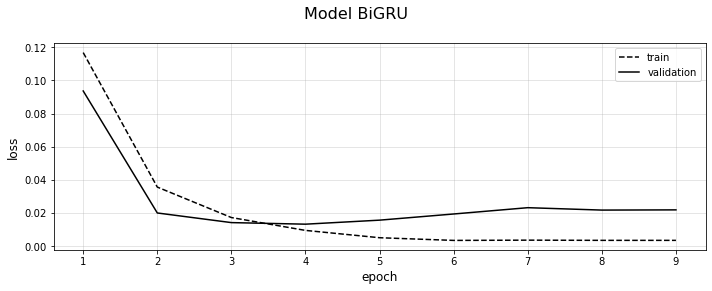

In [77]:
plot_history(history_bi_gru, "Model BiGRU", loss_only=True)

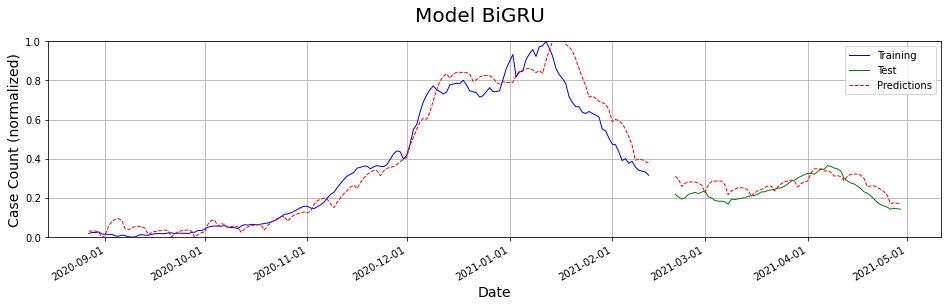

In [78]:
train_predictions = model_bi_gru.predict(X_train)
test_preds = model_bi_gru.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model BiGRU', fontsize=20, y=1.00)
fig.show()

In [79]:
# Evalute Model
evaluate_model("BiGRU", y_train.flatten(), train_predictions.flatten(), train=True)
evaluate_model("BiGRU", y_test.flatten(), test_preds.flatten())

## Bidirectional LSTM

In [80]:
# Define Bidirectional LSTM Model
model_bi_lstm = Sequential()
model_bi_lstm.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_lstm.add(Bidirectional(LSTM(n_units_1, return_sequences = True)))
model_bi_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_bi_lstm.add(Bidirectional(LSTM(n_units_2)))
model_bi_lstm.add(Dense(1, activation='linear'))

# Compile model
model_bi_lstm.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_bi_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 7, 128)            35840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 77,121
Trainable params: 77,121
Non-trainable params: 0
_________________________________________________________________


In [81]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_bi_lstm.load_weights(os.path.join(MODELS_DIR,'model_bi_lstm.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_bi_lstm.pkl'), "rb") as filehandler:
        history_bi_lstm = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_bi_lstm = model_bi_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_bi_lstm = history_bi_lstm.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_bi_lstm.pkl'), "wb") as filehandler:
        pickle.dump(history_bi_lstm, filehandler)
    # save model weights for future use
    model_bi_lstm.save_weights(os.path.join(MODELS_DIR,'model_bi_lstm.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 5s 66ms/step - loss: 0.1678 - val_loss: 0.2283
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0754 - val_loss: 0.0832
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0471 - val_loss: 0.0262
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0159
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0176 - val_loss: 0.0135
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0134
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0178
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0227
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0227
Epoch 10/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0238
Epoch 11/50
17/17 

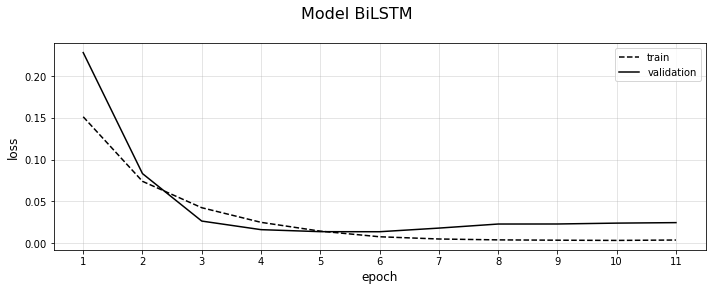

In [82]:
plot_history(history_bi_lstm, "Model BiLSTM", loss_only=True)

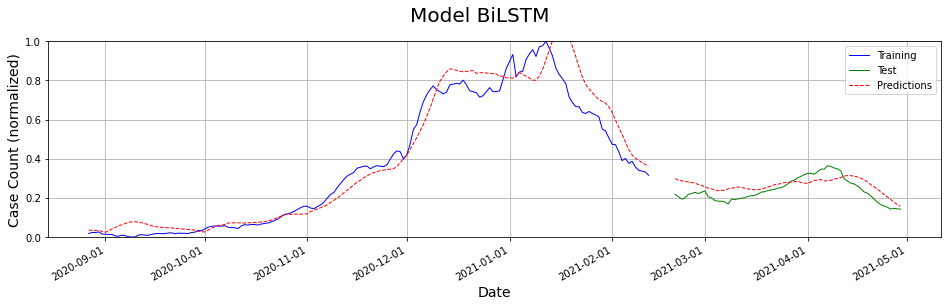

In [83]:
train_predictions = model_bi_lstm.predict(X_train)
test_preds = model_bi_lstm.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model BiLSTM', fontsize=20, y=1.00)
fig.show()

In [84]:
# Evalute Model
evaluate_model("BiLSTM", y_train.flatten(), train_predictions.flatten(), train=True)
evaluate_model("BiLSTM", y_test.flatten(), test_preds.flatten())

### Interpretation of Deep Learning Models

While all the deep learning models(GRU, LSTM, CNN, Bidirectional models) have similar predictive capabilities, there are suble differences in their forecasting trends. In all the models, the predicted values are lagged by 5-6 days when compared to the train and test set. 

CNN: 
The predicted values of the CNN model project high bias and high variance. The predicted values fluctuate heavily and also do not align with the training and test data.

GRU and LSTM:
The GRU and LSTM models have very similar performance. They are unable to predict the rise and dip in the trend line accurately. This shows that the models have high bias but low variance. 

Bi-GRU:
The predicted values of the Bi-GRU model fluctuate heavily and also do not align with the training and test data.

Bi-LSTM:
The variance in the predicted results is not very high but the trend does not align well with the training and test data, resulting in high bias.

<a id="model6"></a>

## XGBoost

[Return to contents](#contents)

In [85]:
X_train_xg, y_train_xg = df_train[predictor_variables].astype(float), df_train[response_variable].astype(float)
X_test_xg, y_test_xg = df_test[predictor_variables].astype(float), df_test[response_variable].astype(float)

In [86]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_xg, y_train_xg,
        eval_set=[(X_train_xg, y_train_xg), (X_test_xg, y_test_xg)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:0.25161	validation_1-rmse:0.21046
[1]	validation_0-rmse:0.17940	validation_1-rmse:0.15757
[2]	validation_0-rmse:0.12836	validation_1-rmse:0.11574
[3]	validation_0-rmse:0.09234	validation_1-rmse:0.09083
[4]	validation_0-rmse:0.06662	validation_1-rmse:0.07237
[5]	validation_0-rmse:0.04841	validation_1-rmse:0.06016
[6]	validation_0-rmse:0.03547	validation_1-rmse:0.05042
[7]	validation_0-rmse:0.02636	validation_1-rmse:0.04294
[8]	validation_0-rmse:0.01986	validation_1-rmse:0.03893
[9]	validation_0-rmse:0.01517	validation_1-rmse:0.03538
[10]	validation_0-rmse:0.01182	validation_1-rmse:0.03371
[11]	validation_0-rmse:0.00946	validation_1-rmse:0.03174
[12]	validation_0-rmse:0.00778	validation_1-rmse:0.03028
[13]	validation_0-rmse:0.00658	validation_1-rmse:0.02927
[14]	validation_0-rmse:0.00560	validation_1-rmse:0.02914
[15]	validation_0-rmse:0.00493	validation_1-rmse:0.02837
[16]	validation_0-rmse:0.00444	validation_1-rmse:0.02778
[17]	validation_0-rmse:0.00394	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Text(0.5, 0, 'Feature Importance')

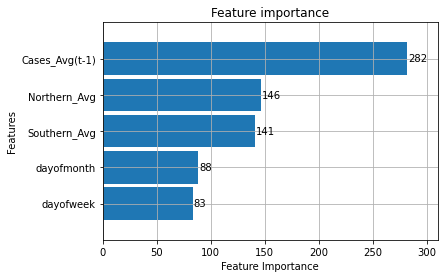

In [87]:
_ = plot_importance(reg, height=0.9)
plt.xlabel('Feature Importance')

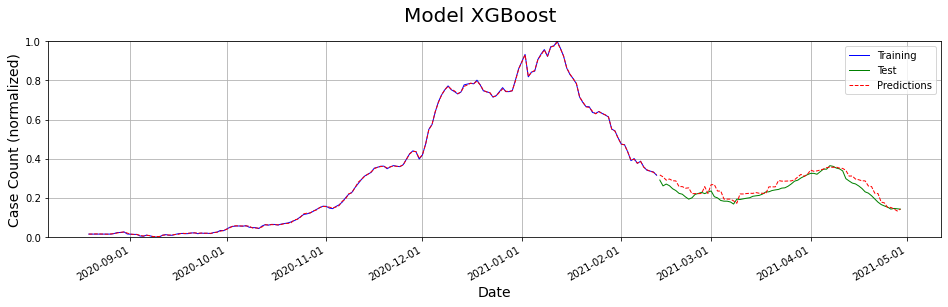

In [88]:
train_predictions = reg.predict(X_train_xg)
test_preds = reg.predict(X_test_xg)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train_xg, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test_xg, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model XGBoost', fontsize=20, y=1.00)
fig.show()

In [89]:
# Evalute Model
evaluate_model("XGBoost", y_train_xg, train_predictions, train=True)
evaluate_model("XGBoost", y_test_xg, test_preds)

#### Interpretation

* The model fits the training data perfectly but is unable to predict the test set with high precision. While the model does not have high bias, the wiggly nature of the predicted output indicates high variance.

* The plot of variable_importance shows that the output of the persistence model(Cases_Avg(t-1))is the most importance variable in the model and contributes heavily to the predictions. This can be attributed to the correct functional use of covid cases of the past to estimate the covid cases of the future. The Northen_Avg and Southern_Avg are the next most important variables in predicting covid cases. The time series variables such as day of month and day of week are the least important variables. 


In [90]:
def highlight_cols(s):
    if s.name in ["RMSE", "MAE", "MAPE"]:
        is_min_max = s == s.min()
    elif s.name in ['Correlation Coeff','R2 Score']:
        is_min_max = s == s.max()
    else:
        is_min_max = [False for _ in range(s.shape[0])]
    return ['background: lightgreen' if cell else '' for cell in is_min_max]

<a id="part7"></a>

## MODEL EVALUATION & INTERPRETATION

[Return to contents](#contents)

In [91]:
allModels = glob.glob(os.path.join(MODELS_DIR, "*test.json"))
allData = []
for model_file in allModels:
    with open(model_file) as fp:
        model_data = json.load(fp)
        allData.append(model_data)

df_evaluation_test = pd.DataFrame.from_dict(allData)

In [92]:
df_evaluation_test.sort_values(by='RMSE', inplace=True)
df_evaluation_test.style.apply(highlight_cols)

,Time,Model,RMSE,MAE,MAPE,Correlation Coeff,R2 Score
0,2021-05-10 20:49:42.429,Persistence,0.011971,0.009323,0.039842,0.978866,0.956400
1,2021-05-10 20:49:42.653,Linear,0.012541,0.009544,0.039714,0.975801,0.952148
2,2021-05-10 20:49:42.722,Polynomial Order: 2,0.015082,0.012059,0.051714,0.967444,0.930794
5,2021-05-10 20:51:25.952,GAM,0.018764,0.015906,0.069615,0.946700,0.892877
3,2021-05-10 20:49:42.760,Polynomial Order: 3,0.021983,0.017335,0.076231,0.935827,0.852975
11,2021-05-10 20:52:27.514,XGBoost,0.027387,0.022414,0.099431,0.950496,0.771796
10,2021-05-10 20:52:26.913,BiLSTM,0.049001,0.044370,0.202854,0.738394,0.323811
9,2021-05-10 20:52:18.727,BiGRU,0.050333,0.042451,0.202467,0.759206,0.286552
8,2021-05-10 20:52:10.966,LSTM,0.053947,0.047769,0.224213,0.706378,0.180405
7,2021-05-10 20:51:59.157,GRU,0.058247,0.049259,0.237743,0.750577,0.044563


### Selecting best model


As mentioned in the earlier section, since this is a regression problem with a strong underlying linear relationship, RMSE, MAE and MAPE have been used to compare models.


From the table above, we can infer the following:

* While persistence model has performed very well, Linear Regression and Polynomial Regression with lower order polynomials have outperformed all of the Deep Learning and XGBoost models with respect to their RMSE values.  


* The R-Squared values of Persistence, Linear Regression, lower order polynomial regression and XGBoost are highly positive indicating that the predictor variables have been able to explain the variance in the response variable well. All these models outperformed deep learning neural network models here as well.

**Based on the above mentioned points, for the current problem with the existing datasets, Linear Regression would be the best model to use**


<a id="part8"></a>

## CONCLUSION & NEXT STEPS

Covid-19 data collection with respect to waste-water-management is very limited. To improve the predictive capability of the models we developed, we would like to add proxy variables to the models such as social media data analysis and clinical data.

Use deconvolution method to utilize number of deaths and extrapolate the number of cases in each county. This might help reduce noise in the dataset. 

Time series decomposition of the training data shows that there could be an underlying seasonal factor in the data. We accounted for this by splitting the date variable into day-of-month and day-of-week.

Adding the output of the persistence model as an input variable has improved the predictive capabilities of all models. Auto regressive models may still end up being more powerful than using proxy predictor variables for this particular problem.

[Return to contents](#contents)

<a id="part9"></a>

## ACKNOWLEDGMENTS

We acknowledge and thank the contributions of the following people for their help and guidance with this project.
 
Mentor: Dr. Mauricio Santillana 
CS109b Teaching Staff - Pavlos Protopapas, Mark Glickman, Chris Tanner 
Teaching Fellows and Teaching Assistants
Fellow Students of CS109b (Spring’ 2021)


[Return to contents](#contents)


## REFERENCES

Wu et al. SARS-CoV-2 titers in wastewater foreshadow dynamics and clinical presentation of new COVID-19 cases (2020 doi: https://doi.org/10.1101/2020.06.15.20117747)
 

https://www.mwra.com/biobot/biobotdata.htm
 

https://www.mass.gov/info-details/covid-19-response-reporting#covid-19-interactive-data-dashboard-
 

Yang et al. Accurate estimation of influenza epidemics using Google search data via ARGO (2015, https://doi.org/10.1073/pnas.1515373112)
Center for Disease control  https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/wastewater-surveillance.html
 

Towards the Use of Neural Networks for Influenza Prediction at Multiple Spatial Resolution https://arxiv.org/abs/1911.02673
 

Analyzing changes in respiratory rate to predict the risk of COVID-19 infection. https://www.medrxiv.org/content/10.1101/2020.06.18.20131417v2
 

Surveillance of Wastewater for Early Epidemic Prediction (SWEEP):
Environmental and health security perspectives in the post COVID-19 Anthropocene

https://www.journals.elsevier.com/environmental-research